# Bayesian Meta Control

This notebook illustrates how I formalize automatic and controlled processing as well as meta-control in a Bayesian network. There are multiple exercises that either ask you to change some simple values in the code (but not the code itself) or to think about what's happening conceptually.

**Notice**: You cannot modify this notebook directly, but you have to save your own copy to work on ("File" -> "Save a copy on Drive").

In [5]:
# When running on colab, uncomment the line below to install pgmpy temporarily (this takes a few minutes)
#!pip install pgmpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import BeliefPropagation
from scipy.stats import entropy

## Definitions

*   **Automatic processing**: Information processing that is solely based on direct associations between observed features of the environment (e.g., a stimulus is a psychological experiment) and latent variables, such as actions. For the case of actions, this is also referred to as *automatic response tendency*.
*   **Controlled processing**: Information processing based on the environment *and one's goals*. This requires to consider the consequences of latent variables such as actions and how they relate to the goal.
*   **Meta-control**: A higher-order process that determines lower-level information processing. One particular example is to what extent an agent should rely on automatic and/or controlled processing when making a decision. But there are many others, like updating task-relevant information or balancing exploration and exploitation.
*   **Proper learning**: Changing the parameters of the model, here of the conditional probability distributions (CPDs)
*   **Apparent learning**: Changing higher-order beliefs of the model, resulting in a change of information processing without changing model parameters.



# Chapter 1: Probabilistic formalization

## Automatic processing

Automatic processing could be any learnable function that takes in features of the environment and produces a distribution over, e.g., actions. Here, we use the simplest example, namely a lookup table - or in Bayesian terms the conditional probability distribution specifying the dependency between a categorically distributed environmental feature $s_0$ and an also categorically distributed action $a$, defined as $p(a | s_0)$. This yields a simple generative model $p(a, s_0) = p(a | s_0)p(s_0)$


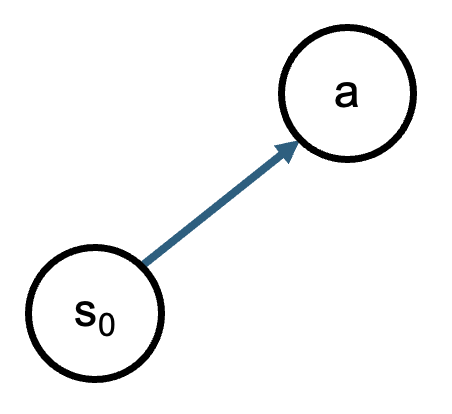

The following code implements this model, were we assume two features, say "red" ($s_0 = 0$) and "green" ($s_0 = 1$), and two actions, say "left" ($a = 0$) and "right" ($a = 1$).

In [6]:
# Define dependencies
auto_model = BayesianNetwork([
    ('s0', 'a'),
])

# Define priors and CPDs
cpd_s0 = TabularCPD('s0', 2, [[.5], [.5]])  # defines p(s_0)
cpd_a = TabularCPD('a', 2, evidence=['s0'], evidence_card=[2],
                   values=[
                       [.5, .5],
                       [.5, .5]
                   ])  # defines p(a | s_0)
print(f'Automatic processing function: \n{cpd_a}')

# Add CPDs to the model
auto_model.add_cpds(cpd_s0, cpd_a)

Automatic processing function: 
+------+-------+-------+
| s0   | s0(0) | s0(1) |
+------+-------+-------+
| a(0) | 0.5   | 0.5   |
+------+-------+-------+
| a(1) | 0.5   | 0.5   |
+------+-------+-------+


We can now perform inference in this very simple model

In [7]:
auto_inference = BeliefPropagation(auto_model)
posterior_a = auto_inference.query(['a'], evidence={'s0': 0})
print(f'Automatic response tendency after observing s0 = 0 (green): \n{posterior_a}')

Automatic response tendency after observing s0 = 0 (green): 
+------+----------+
| a    |   phi(a) |
+======+==========+
| a(0) |   0.5000 |
+------+----------+
| a(1) |   0.5000 |
+------+----------+


### Exercise 1
Right now, there is no automatic processing because the dependency/function between $s_0$ and $a$ is completely uninformative. Change this, such that the action "left" is more likely when observing "red" and the action "right" is more likely when observing "green".

## Controlled processing

Controlled processing assumes (1) that we have an understanding of how an action leads to a consequence and (2) that we know which consequence we prefer. In other words, we have some function that predicts a consequence $s_1$ when given an action $a$ that is performed in an environmental state $s_0$. Again, we can describe this as a simple generative model, $p(a, s_0, s_1) = p(s_1 | a, s_0)p(a)p(s_0)$, with lookup tables as CPDs. Note, however, that in principle the function can be arbitrarily complex.

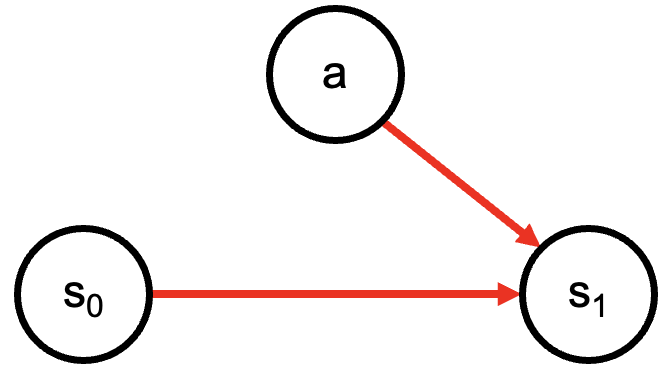

We'll specify the values of $a$ and $s_0$ as before and assume that there are two consequences, "correct" ($s_1 = 0$) and "incorrect" ($s_1 = 1$). The following code implements this model analogously and performs action inference

In [8]:
# Define dependencies
contr_model = BayesianNetwork([
    ('s0', 's1'),
    ('a', 's1'),
])

# Define priors and CPDs
cpd_s0 = TabularCPD('s0', 2, [[.5], [.5]])  # defines p(s_0)
cpd_a = TabularCPD('a', 2, [[.5], [.5]])  # defines p(a)
cpd_s1 = TabularCPD('s1', 2, evidence=['a', 's0'], evidence_card=[2, 2],
                    values=[
                        [.95, .05, .05, .95],
                        [.05, .95, .95, .05]
                    ])  # defines p(s_1 | a, s_0)
print(f'"Consequence prediction engine": \n{cpd_s1}')

# Add CPDs to the model
contr_model.add_cpds(cpd_s0, cpd_a, cpd_s1)

"Consequence prediction engine": 
+-------+-------+-------+-------+-------+
| a     | a(0)  | a(0)  | a(1)  | a(1)  |
+-------+-------+-------+-------+-------+
| s0    | s0(0) | s0(1) | s0(0) | s0(1) |
+-------+-------+-------+-------+-------+
| s1(0) | 0.95  | 0.05  | 0.05  | 0.95  |
+-------+-------+-------+-------+-------+
| s1(1) | 0.05  | 0.95  | 0.95  | 0.05  |
+-------+-------+-------+-------+-------+


In [9]:
contr_inference = BeliefPropagation(contr_model)
posterior_a = contr_inference.query(['a'], evidence={'s0': 0, 's1': 0})
print(f'Goal directed action selection, assuming s0 = 0 (green) and goal s1 = 0 (correct): \n{posterior_a}')

Goal directed action selection, assuming s0 = 0 (green) and goal s1 = 0 (correct): 
+------+----------+
| a    |   phi(a) |
+======+==========+
| a(0) |   0.9500 |
+------+----------+
| a(1) |   0.0500 |
+------+----------+


### Exercise 2
Our generative model can't predict the consequences of actions well. Change this, assuming that in our world it is only correct to respond "left" to "red" and "right" to "green". Your agent should be 95% sure about which action to is correct.

### Exercise 3

Conceptually, what is the difference between the formalization of automatic and controlled behavior? Think about what is being predicted and what is being inferred. Based on this, which type of processing allows for more flexible behavior?

## Combining automatic and controlled processing
As should be obvious from the model graphs above, automatic and controlled processing can easily be combined, where our generative model is now defined as $p(a, s_0, s_1) = p(s_1 | a, s_0)p(a | s_0)p(s_0)$

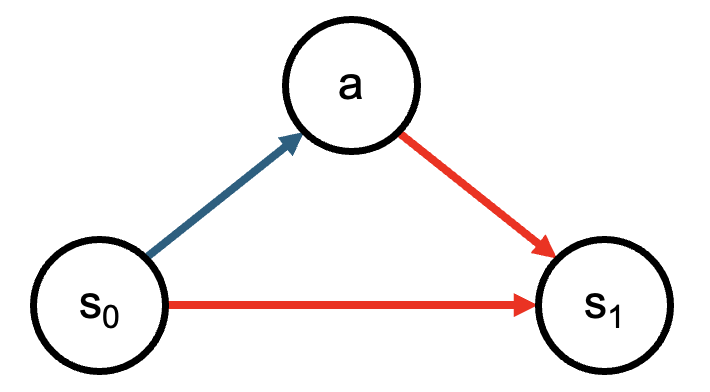

The following code implements this.

In [10]:
# Define dependencies
comb_model = BayesianNetwork([
    ('s0', 'a'),
    ('s0', 's1'),
    ('a', 's1'),
])

# Define priors and CPDs
cpd_s0 = TabularCPD('s0', 2, [[.5], [.5]])  # defines p(s_0)
cpd_a = TabularCPD('a', 2, evidence=['s0'], evidence_card=[2],
                   values=[
                        [.7, .3],
                        [.3, .7]
                    ])  # defines p(a | s_0)
print(f'"Automatic processing function": \n{cpd_a}')
cpd_s1 = TabularCPD('s1', 2, evidence=['a', 's0'], evidence_card=[2, 2],
                    values=[
                        [.95, .05, .05, .95],
                        [.05, .95, .95, .05]
                    ])  # defines p(s_1 | a, s_0)
print(f'"Consequence prediction engine": \n{cpd_s1}')

# Add CPDs to the model
comb_model.add_cpds(cpd_s0, cpd_a, cpd_s1)

"Automatic processing function": 
+------+-------+-------+
| s0   | s0(0) | s0(1) |
+------+-------+-------+
| a(0) | 0.7   | 0.3   |
+------+-------+-------+
| a(1) | 0.3   | 0.7   |
+------+-------+-------+
"Consequence prediction engine": 
+-------+-------+-------+-------+-------+
| a     | a(0)  | a(0)  | a(1)  | a(1)  |
+-------+-------+-------+-------+-------+
| s0    | s0(0) | s0(1) | s0(0) | s0(1) |
+-------+-------+-------+-------+-------+
| s1(0) | 0.95  | 0.05  | 0.05  | 0.95  |
+-------+-------+-------+-------+-------+
| s1(1) | 0.05  | 0.95  | 0.95  | 0.05  |
+-------+-------+-------+-------+-------+


In [11]:
comb_inference = BeliefPropagation(comb_model)
posterior_a = comb_inference.query(['a'], evidence={'s0': 0, 's1': 0})
print(f'Action selection based on both controlled and automatic processing, assuming s0 = 0 (green) and goal s1 = 0 (correct): \n{posterior_a}')

Action selection based on both controlled and automatic processing, assuming s0 = 0 (green) and goal s1 = 0 (correct): 
+------+----------+
| a    |   phi(a) |
+======+==========+
| a(0) |   0.9779 |
+------+----------+
| a(1) |   0.0221 |
+------+----------+


### Exercise 4
Does this particular combination of automatic and controlled processing lead to more accurate behavior compared to each type of processing alone? Is it possible to change the model such that the combination leads to *less* accurate behavior? What does this mean in practice?

### Exercise 5
Based on your knowledge of Bayesian inference, how do you think the information from automatic processing and goal-directed processing is integrated? You can also play around with the values to get a feeling for it.

## Meta-control

One function of meta-control is to balance automatic and controlled processing. For example, the automatic response tendency defined above might be useful or valid in some situations but not in others. Meta-control should have a way of monitoring this and adjusting the reliance on the automatic response tendency accordingly.

To formalize this, we introduce an abstract latent variable, which we call *context* $c_t$ that informs the automatic process, i.e., instead of defining it as $p(a | s_0)$ we now define it as $p(a | s_0, c_t)$. The idea is that we can have different contexts with different functions from $s_0$ to $a$ and switch between them by changing our belief over contexts. To illustrate this, we assume two contexts, one with a strong response tendency ($c_t = 0$) and one with no informative response tendency ($c_t = 1$). Thus, by switching between contexts, we can virtually turn the response tendency on or off.

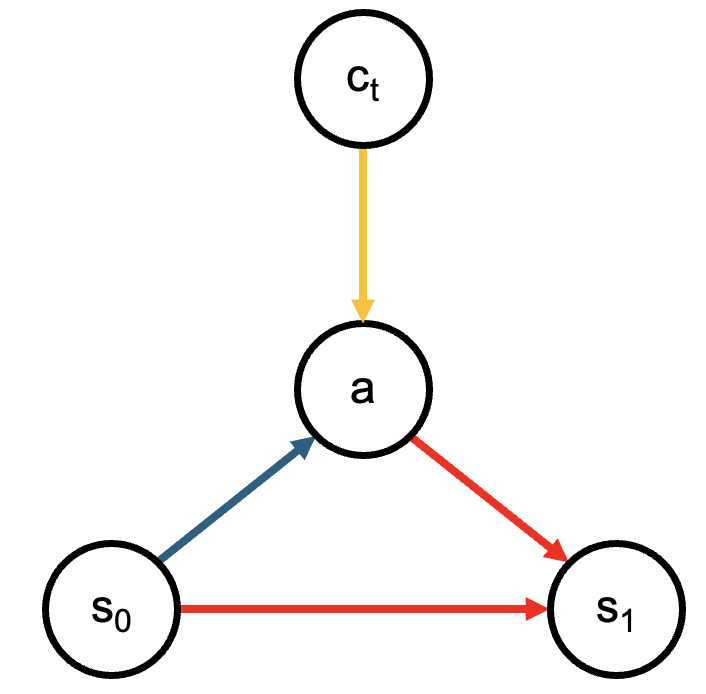

In [12]:
# Define dependencies
meta_model = BayesianNetwork([
    ('s0', 'a'),
    ('s0', 's1'),
    ('a', 's1'),
    ('c', 'a'),
])

# Define priors and CPDs
cpd_s0 = TabularCPD('s0', 2, [[.5], [.5]])  # defines p(s_0)
cpd_c = TabularCPD('c', 2, [[.5], [.5]])  # defines p(c)
cpd_a = TabularCPD('a', 2, evidence=['c', 's0'], evidence_card=[2, 2],
                   values=[
                        [.99, .01, .5, .5],
                        [.01, .99, .5, .5]
                    ])  # defines p(a | c, s_0)
print(f'"Automatic processing function": \n{cpd_a}')
cpd_s1 = TabularCPD('s1', 2, evidence=['a', 's0'], evidence_card=[2, 2],
                    values=[
                        [.95, .05, .05, .95],
                        [.05, .95, .95, .05]
                    ])  # defines p(s_1 | a, s_0)
print(f'"Consequence prediction engine": \n{cpd_s1}')

# Add CPDs to the model
meta_model.add_cpds(cpd_s0, cpd_c, cpd_a, cpd_s1)

"Automatic processing function": 
+------+-------+-------+-------+-------+
| c    | c(0)  | c(0)  | c(1)  | c(1)  |
+------+-------+-------+-------+-------+
| s0   | s0(0) | s0(1) | s0(0) | s0(1) |
+------+-------+-------+-------+-------+
| a(0) | 0.99  | 0.01  | 0.5   | 0.5   |
+------+-------+-------+-------+-------+
| a(1) | 0.01  | 0.99  | 0.5   | 0.5   |
+------+-------+-------+-------+-------+
"Consequence prediction engine": 
+-------+-------+-------+-------+-------+
| a     | a(0)  | a(0)  | a(1)  | a(1)  |
+-------+-------+-------+-------+-------+
| s0    | s0(0) | s0(1) | s0(0) | s0(1) |
+-------+-------+-------+-------+-------+
| s1(0) | 0.95  | 0.05  | 0.05  | 0.95  |
+-------+-------+-------+-------+-------+
| s1(1) | 0.05  | 0.95  | 0.95  | 0.05  |
+-------+-------+-------+-------+-------+


In [13]:
meta_inference = BeliefPropagation(meta_model)
posterior_a = meta_inference.query(['a'], evidence={'s0': 0, 's1': 0})
posterior_c = meta_inference.query(['c'], evidence={'s0': 0, 's1': 0})
print(f'Posterior belief over actions, assuming s0 = 0 (green) and goal s1 = 0 (correct): \n{posterior_a}')
print(f'Posterior belief over contexts, assuming s0 = 0 (green) and goal s1 = 0 (correct): \n{posterior_c}')

Posterior belief over actions, assuming s0 = 0 (green) and goal s1 = 0 (correct): 
+------+----------+
| a    |   phi(a) |
+======+==========+
| a(0) |   0.9823 |
+------+----------+
| a(1) |   0.0177 |
+------+----------+
Posterior belief over contexts, assuming s0 = 0 (green) and goal s1 = 0 (correct): 
+------+----------+
| c    |   phi(c) |
+======+==========+
| c(0) |   0.6530 |
+------+----------+
| c(1) |   0.3470 |
+------+----------+


When setting up the model this way, crucially, we also automatically gain information about which context we are currently in. This information stems from the level of conflict/congruency between the automatic and controlled process, i.e., the agreement between our response tendency and our goal.

### Exercise 6
In the situation specified above, we seem to be in a context in which the response tendency is "valid", right? What effect does this have on the performance of the model? Create a situation in which the response tendency is "invalid" and observe how our posterior belief over contexts changes.

### Exercise 7
Try to manually up- and down-regulate the effective strength of the automatic process in two ways:
1.   By changing $p(a | c_t, s_0)$
2.   Without changing $p(a | c_t, s_0)$

Do you understand the difference between *proper* and *apparent* learning of the automatic response tendency?

# Chapter 2: Cost-benefit analysis

In cognitive science it is commonly assumed that automatic processing is "easy" for the cognitive system, while controlled processing is "hard". This is the reason why we need meta-control to balance the two in the first place.

This is often explained on the basis that controlled processing taps into a cognitive resource that is limited (a good example for this is attention), whereas automatic processing does not. Meta-control then should implement a trade-off between the additional costs of controlled processing against the additional benefits.

There are two issue with this that I want to address

1.   Why is automatic processing easy, but controlled processing is hard? What does "hard" and "easy" even mean? In fact, things that are classically interpreted as automatic can be computationally complex, such as object recognition.
2.   How can the costs and benefits be traded-off efficiently? In many computational proposals (maximizing utility etc.), the computational complexity arguably surpasses the complexity of controlled processing - which we wanted to avoid because of its complexity in the first place.



## The informational cost of controlled processing (over automatic processing)

A way to define the difficulty of decision making is based on how much information is required to change one's beliefs. In information theoretical terms, this is defined as the KL-divergence between the prior and posterior belief. Below is an example:

In [14]:
prior = np.array([.5, .5])
posterior = np.array([.9, .1])  # feel free to play around with these values and see what the cost is
cost = entropy(posterior, prior)
print(f'Cost: {cost:.3f} nats')

Cost: 0.368 nats


Now let's look at the cost of the decision making process in the example above. Let's start with the model that combines automatic and controlled processing.

The way I think about it is that the process happens in two stages. Firstly we perceive the environment, i.e., we condition our model on $s_0$. This will give us our prior belief. Secondly, we include goal-directed information, i.e., condition on $s_1$. This will give us our goal-directed posterior.



In [15]:
# Define dependencies (just repeating code from above here)
comb_model = BayesianNetwork([
    ('s0', 'a'),
    ('s0', 's1'),
    ('a', 's1'),
])

# Define priors and CPDs
cpd_s0 = TabularCPD('s0', 2, [[.5], [.5]])  # defines p(s_0)
cpd_a = TabularCPD('a', 2, evidence=['s0'], evidence_card=[2],
                   values=[
                        [.7, .3],
                        [.3, .7]
                    ])  # defines p(a | s_0)
#print(f'"Automatic processing function": \n{cpd_a}')
cpd_s1 = TabularCPD('s1', 2, evidence=['a', 's0'], evidence_card=[2, 2],
                    values=[
                        [.95, .05, .05, .95],
                        [.05, .95, .95, .05]
                    ])  # defines p(s_1 | a, s_0)
#print(f'"Consequence prediction engine": \n{cpd_s1}')

# Add CPDs to the model
comb_model.add_cpds(cpd_s0, cpd_a, cpd_s1)

# Perform inference
comb_inference = BeliefPropagation(comb_model)
prior = comb_inference.query(['a'], evidence={'s0': 0}).values
print(f'Prior belief: {prior}')
posterior = comb_inference.query(['a'], evidence={'s0': 0, 's1': 0}).values
print(f'Posterior belief: {posterior}')
cost = entropy(posterior, prior)
print(f'Cost: {cost:.3f} nats')

Prior belief: [0.7 0.3]
Posterior belief: [0.97794118 0.02205882]
Cost: 0.269 nats


As you might have already understood, this is the additional cost that controlled processing incurrs over automatic processing. My argument is that the cost of automatic processing can be virtually neglected because it is a simple function, e.g., a forward pass through a black-box neural network or in our case looking up a value in a table. For controlled processing, this is not the case because we have learned the predictive function in the other direction, so to speak, and therefore have to invert it. In our case this is admitteldy also trivial but in the general case it isn't.

### Exercise 8

By changing $p(a | s_0)$, investigate the interaction between automatic and controlled processing. What conclusion can you draw about the interaction of the two types of processing?

## The benefit of controlled processing (over automatic processing)

The benefit of controlled processing should describe how likely we are to reach our goal. Again, we can define this in information-theoretic terms as the expected likelihood of observing the goal under our posterior belief, i.e., the negative cross entropy between posterior and likelihood. Higher (less negative) values are more beneficial.

In [16]:
likelihood = np.array([0.95, 0.05])  # p(o1 = 0 | a)
posterior = np.array([.9, .1])  # p(a | o1 = 0)  again, please play around with these values
benefit = -1 * (entropy(posterior) + entropy(posterior, likelihood))
print(f'Benefit: {benefit:.3f} nats')

Benefit: -0.346 nats


## Bayesian inference and the implicit cost-benefit analysis

Now that we have defined cost and benefits with a common unit (nats), it is straight-forward to balance them, namely by maximizing [benefits - costs] or equivalently minimizing [costs - benefits].

### Exercise 9

Below, the prior belief is already defined. Your task is to try out different values for possible posterior beliefs (just set them by hand). Try to find values that optimize (i.e., minimize!) the trade-off between costs and benefits

In [17]:
prior = comb_inference.query(['a'], evidence={'s0': 0}).values
print(f'Prior belief: {prior}')
posterior = np.array([.9, .1])  # change these values
print(f'Posterior belief: {posterior}')
cost = entropy(posterior, prior)
print(f'Cost: {cost:.3f} nats')
benefit = -1 * (entropy(posterior) + entropy(posterior, likelihood))
print(f'Benefit: {benefit:.3f} nats')
print(f'Trade-off: {cost - benefit:.3f} nats')

Prior belief: [0.7 0.3]
Posterior belief: [0.9 0.1]
Cost: 0.116 nats
Benefit: -0.346 nats
Trade-off: 0.462 nats


Now let's compare this to the true posterior defined by Bayes' Rule. Could you beat it?

In [18]:
prior = comb_inference.query(['a'], evidence={'s0': 0}).values
print(f'Prior belief: {prior}')
posterior = comb_inference.query(['a'], evidence={'s0': 0, 's1': 0}).values
print(f'Posterior belief: {posterior}')
cost = entropy(posterior, prior)
print(f'Cost: {cost:.3f} nats')
benefit = -1 * (entropy(posterior) + entropy(posterior, likelihood))
print(f'Benefit: {benefit:.3f} nats')
print(f'Trade-off: {cost - benefit:.3f} nats')

Prior belief: [0.7 0.3]
Posterior belief: [0.97794118 0.02205882]
Cost: 0.269 nats
Benefit: -0.116 nats
Trade-off: 0.386 nats


In fact, you can't beat the true posterior because it defines the optimal trade-off between costs and benefits as we defined them.

What you effectively did when entering possible posterior beliefs, was to minimize an upper bound on the optimal cost-benefit trade-off. This upper bound is also called the **variational free energy** (or, when instead maximizing the lower bound on the benefit-cost trade-off, the ELBO). In other words, you were just minimizing free energy to make a behavioral decision!

This is important because we can now use all sorts of algorithms that approximate the true posterior (VI, MCMC) and we get a built-in cost-benefit analysis. No need to ever estimate, monitor, or compare cost and benefit values - it just happens implicitly. Of course, this only works for our particular definition of costs and benefits. So, you couldn't for instance just add another cost term.

## The informational cost of meta-control

That Bayesian inference defines an optimum of an accuracy-complexity trade-off is nothing new at all. This just applies it to a model of automatic and controlled processing. But we can go even further by considering the meta-control model defined in the previous section.

In [19]:
# Define dependencies (just repeating the code from above here)
meta_model = BayesianNetwork([
    ('s0', 'a'),
    ('s0', 's1'),
    ('a', 's1'),
    ('c', 'a'),
])

# Define priors and CPDs
cpd_s0 = TabularCPD('s0', 2, [[.5], [.5]])  # defines p(s_0)
cpd_c = TabularCPD('c', 2, [[.5], [.5]])  # defines p(c)
cpd_a = TabularCPD('a', 2, evidence=['c', 's0'], evidence_card=[2, 2],
                   values=[
                        [.99, .01, .5, .5],
                        [.01, .99, .5, .5]
                    ])  # defines p(a | c, s_0)
#print(f'"Automatic processing function": \n{cpd_a}')
cpd_s1 = TabularCPD('s1', 2, evidence=['a', 's0'], evidence_card=[2, 2],
                    values=[
                        [.95, .05, .05, .95],
                        [.05, .95, .95, .05]
                    ])  # defines p(s_1 | a, s_0)
#print(f'"Consequence prediction engine": \n{cpd_s1}')

# Add CPDs to the model
meta_model.add_cpds(cpd_s0, cpd_c, cpd_a, cpd_s1)

# Perform inference
meta_inference = BeliefPropagation(meta_model)
prior = meta_inference.query(['a', 'c'], evidence={'s0': 0}).values
print(f'Prior belief a: {prior.sum(axis=1)}')
posterior = meta_inference.query(['a', 'c'], evidence={'s0': 0, 's1': 0}).values
print(f'Posterior belief a: {posterior.sum(axis=1)}')
print(f'Posterior belief c: {posterior.sum(axis=0)}')
cost = entropy(posterior.flatten(), prior.flatten())
print(f'Cost: {cost:.3f} nats')
benefit = -1 * (entropy(posterior.sum(axis=1)) + entropy(posterior.sum(axis=1), likelihood))
print(f'Benefit: {benefit:.3f} nats')
print(f'Trade-off: {cost - benefit:.3f} nats')

Prior belief a: [0.745 0.255]
Posterior belief a: [0.98230396 0.01769604]
Posterior belief c: [0.65301874 0.34698126]
Cost: 0.224 nats
Benefit: -0.103 nats
Trade-off: 0.328 nats


### Exercise 10
Change the previous model (without context) such that the prior is the same to the current model (with context). Then observe how the cost and benefit values compare if $s_1 = 0$ (correct) and if $s_1 = 1$ (incorrect). What do you notice in each case? What does this mean in terms of flexibility of the two models?

The cost term above now contains the change in belief over both actions and contexts. But we can mathematically decompose these two, yielding a separate cost term for controlled processing\* and meta-control.

\* I'll call it "control cost" now but it corresponds to the "cost" from earlier sections

In [20]:
# Compute meta-control cost
prior_c = prior.sum(axis=0)
posterior_c = posterior.sum(axis=0)
meta_control_cost = entropy(posterior_c, prior_c)
print(f'Meta-control cost: {meta_control_cost:.3f} nats')

# Compute control cost: expectation of change in belief over actions under posterior over c
prior_a__c = []
posterior_a__c = []
control_cost__c = []
for c in range(2):
  prior_a__c.append(meta_inference.query(['a'], evidence={'s0': 0, 'c': c}).values)
  posterior_a__c.append(meta_inference.query(['a'], evidence={'s0': 0, 's1': 0, 'c': c}).values)
  control_cost__c.append(entropy(posterior_a__c[c], prior_a__c[c]))
control_cost = posterior_c @ control_cost__c
print(f'Control cost: {control_cost:.3f} nats')
print(f'Total cost: {control_cost + meta_control_cost:.3f} nats')

Meta-control cost: 0.048 nats
Control cost: 0.177 nats
Total cost: 0.224 nats


### Exercise 11
Compare the cost terms of the current model (with context) to the previous model (without context). Think about in which situation the additional cost of meta-control is "worth it" (i.e., results in a lower overall cost compared to not using meta-control).

# Summary

## Key take-aways

1.   We have formalized automatic and controlled processing as well as meta-control in a probabilistic framework
1.   We have defined the relative costs and benefits of these processes in information-theoretic terms
1.   Using Bayesian inference (or approximations thereof), we have implicitly optimized a trade-off between them
1.   We have seen that an abstract latent cause can increase the flexibility of a model

## Drawbacks

1.   Informational cost is not necessarily the same as computational cost, even though they are related
1.   The approach only works for this exact optimality criterion, i.e., you couldn't simply change or add another term

